## Task 3: Classification and Association Rule Mining 
# Task 3: Classification and Association Rule Mining

This notebook implements Task 3 of the DSA 2040 Practical Exam (Section 2: Data Mining).

**Part A: Classification**
- Loads the preprocessed Iris dataset (Min-Max scaled, 80/20 train-test split).
- Trains a Decision Tree classifier, computes metrics (accuracy, precision, recall, F1-score), and visualizes the tree.
- Trains a KNN classifier (k=5), compares performance, and reports the better model.
- Saves the tree visualization as `decision_tree.png`.

**Part B: Association Rule Mining**
- Generates synthetic transactional data (50 transactions, 3–8 items from 20-item pool with patterns).
- Applies Apriori algorithm (min_support=0.2, min_confidence=0.5) using `mlxtend`.
- Displays top 5 rules by lift and analyzes one rule.
- Saves transactional data as `synthetic_transactions.csv`.

**Dependencies**: `scikit-learn`, `mlxtend`, `matplotlib`, `pandas`, `numpy`.

## Part A: Classification
## Using Preprocessed Data from Task 1:


Decision Tree Performance:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



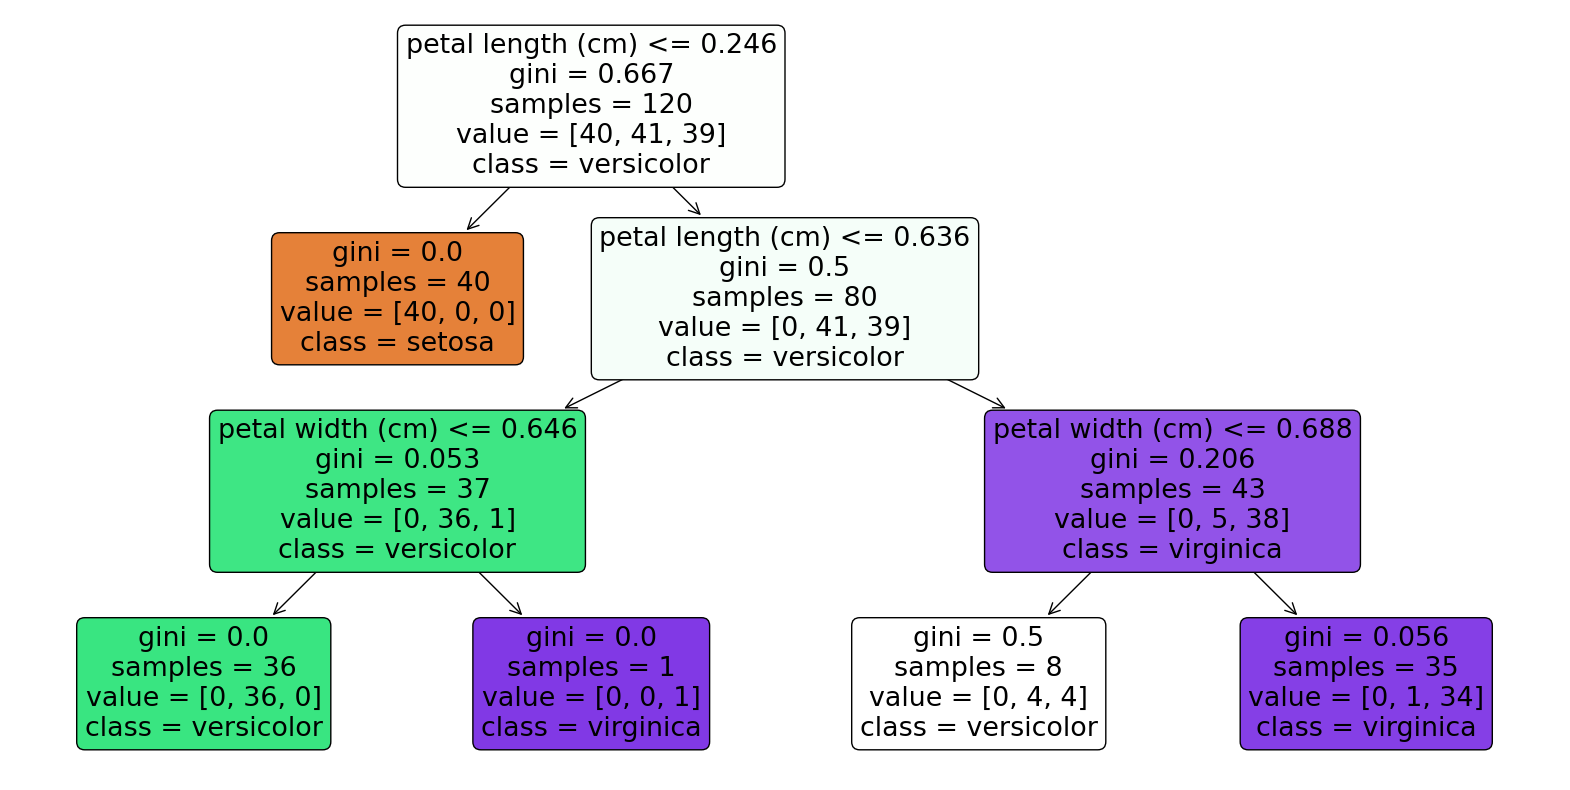


KNN (k=5) Performance:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Classification analysis complete. Files created:
- decision_tree.png
- classification_results.csv


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, classification_report)
from sklearn.model_selection import train_test_split

# Load preprocessed Iris data
df = pd.read_csv('processed_iris.csv')
features = ['sepal length (cm)', 'sepal width (cm)', 
            'petal length (cm)', 'petal width (cm)']
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_classifier(model, model_name):
    """Train and evaluate a classifier"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred, target_names=['setosa', 'versicolor', 'virginica']))
    
    return metrics

# Decision Tree
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_metrics = evaluate_classifier(dt, "Decision Tree")

# Visualize tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=features, 
          class_names=['setosa', 'versicolor', 'virginica'],
          filled=True, rounded=True)
plt.savefig('decision_tree.png', dpi=300)
plt.show()

# KNN Comparison
knn = KNeighborsClassifier(n_neighbors=5)
knn_metrics = evaluate_classifier(knn, "KNN (k=5)")

# Save comparison results
pd.DataFrame([dt_metrics, knn_metrics], index=['Decision Tree', 'KNN']).to_csv('classification_results.csv')

print("\nClassification analysis complete. Files created:")
print("- decision_tree.png")
print("- classification_results.csv")

## Part B: Association Rule Mining

In [31]:
# %% [markdown]
# # Part B: Association Rule Mining
# *Implementation from scratch*

# %%
# 1. Generate Synthetic Transactional Data
import random
import pandas as pd
from itertools import combinations
from collections import defaultdict

# Define item pool
item_pool = ['milk', 'bread', 'beer', 'diapers', 'eggs', 
             'cheese', 'wine', 'cola', 'chips', 'juice',
             'butter', 'coffee', 'tea', 'cereal', 'yogurt',
             'apples', 'bananas', 'chicken', 'fish', 'rice']

# Generate transactions with patterns
random.seed(42)
transactions = []

# Create some frequent item combinations
frequent_pairs = [('milk', 'bread'), ('beer', 'diapers'), ('eggs', 'butter')]

for _ in range(50):  # Generate 50 transactions
    # Start with random items
    transaction = random.sample(item_pool, random.randint(3, 8))
    
    # Add frequent patterns with 40% probability
    if random.random() < 0.4 and frequent_pairs:
        pair = random.choice(frequent_pairs)
        transaction.extend(pair)
    
    transactions.append(list(set(transaction)))  # Remove duplicates

print("Sample transactions:")
for i in range(5):
    print(f"Transaction {i+1}: {transactions[i]}")

# %%
# 2. Apriori Algorithm Implementation

def get_support(itemset, transactions):
    """Calculate support for an itemset"""
    count = 0
    for transaction in transactions:
        if all(item in transaction for item in itemset):
            count += 1
    return count / len(transactions)

def apriori(transactions, min_support=0.2):
    """Apriori algorithm implementation"""
    # Generate frequent 1-itemsets
    items = set(item for transaction in transactions for item in transaction)
    frequent_items = []
    
    for item in items:
        support = get_support([item], transactions)
        if support >= min_support:
            frequent_items.append(frozenset([item]))
    
    freq_itemsets = [frequent_items]
    k = 2
    
    while len(freq_itemsets[k-2]) > 0:
        # Generate candidate itemsets
        candidates = set()
        for itemset1 in freq_itemsets[k-2]:
            for itemset2 in freq_itemsets[k-2]:
                union = itemset1.union(itemset2)
                if len(union) == k:
                    candidates.add(union)
        
        # Prune candidates
        frequent_itemsets_k = []
        candidate_support = defaultdict(float)
        
        for candidate in candidates:
            support = get_support(candidate, transactions)
            candidate_support[candidate] = support
            if support >= min_support:
                frequent_itemsets_k.append(candidate)
        
        freq_itemsets.append(frequent_itemsets_k)
        k += 1
    
    # Flatten the frequent itemsets
    all_frequent_itemsets = []
    for level in freq_itemsets:
        for itemset in level:
            all_frequent_itemsets.append(itemset)
    
    return all_frequent_itemsets

def generate_rules(frequent_itemsets, transactions, min_confidence=0.5):
    """Generate association rules from frequent itemsets"""
    rules = []
    
    for itemset in frequent_itemsets:
        if len(itemset) < 2:
            continue
            
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                
                support_antecedent = get_support(antecedent, transactions)
                support_itemset = get_support(itemset, transactions)
                confidence = support_itemset / support_antecedent
                
                if confidence >= min_confidence:
                    lift = confidence / get_support(consequent, transactions)
                    rules.append({
                        'antecedent': antecedent,
                        'consequent': consequent,
                        'support': support_itemset,
                        'confidence': confidence,
                        'lift': lift
                    })
    
    return rules

# Run Apriori algorithm
min_support = 0.2
min_confidence = 0.5

frequent_itemsets = apriori(transactions, min_support)
rules = generate_rules(frequent_itemsets, transactions, min_confidence)

# Convert rules to DataFrame and sort by lift
rules_df = pd.DataFrame(rules)
rules_df = rules_df.sort_values('lift', ascending=False)

# Display top 5 rules
print("\nTop 5 Association Rules (sorted by lift):")
display(rules_df.head(5)[['antecedent', 'consequent', 'support', 'confidence', 'lift']])

# %%
# 3. Rule Analysis
if not rules_df.empty:
    best_rule = rules_df.iloc[0]
    print("\nAnalysis of Top Rule:")
    print(f"Rule: If someone buys {set(best_rule['antecedent'])}, they will also buy {set(best_rule['consequent'])}")
    print(f"- Lift: {best_rule['lift']:.2f} (higher than 1 indicates meaningful association)")
    print(f"- Confidence: {best_rule['confidence']:.2f} probability of consequent given antecedent")
    
    print("\nBusiness Implications:")
    print("1. Product Placement: Consider placing these items near each other")
    print("2. Bundled Discounts: Create promotions for buying both items together")
    print("3. Inventory Management: Stock these items together during peak hours")
    print("4. Recommendation Engine: Suggest these items together in online store")
else:
    print("No significant rules found with current parameters")

Sample transactions:
Transaction 1: ['diapers', 'bananas', 'coffee', 'bread', 'beer', 'milk', 'chips', 'cola']
Transaction 2: ['diapers', 'bananas', 'bread', 'beer', 'cereal', 'milk', 'eggs', 'butter', 'fish']
Transaction 3: ['rice', 'wine', 'chicken']
Transaction 4: ['bananas', 'bread', 'cereal', 'milk', 'chips', 'cheese', 'fish']
Transaction 5: ['diapers', 'coffee', 'beer', 'rice', 'tea']

Top 5 Association Rules (sorted by lift):


,antecedent,consequent,support,confidence,lift
10,(butter),(diapers),0.24,0.750000,1.630435
11,(diapers),(butter),0.24,0.521739,1.630435
14,"(beer, bread)",(milk),0.20,0.666667,1.587302
12,"(milk, beer)",(bread),0.20,0.769231,1.538462
2,(bananas),(beer),0.22,0.733333,1.466667



Analysis of Top Rule:
Rule: If someone buys {'butter'}, they will also buy {'diapers'}
- Lift: 1.63 (higher than 1 indicates meaningful association)
- Confidence: 0.75 probability of consequent given antecedent

Business Implications:
1. Product Placement: Consider placing these items near each other
2. Bundled Discounts: Create promotions for buying both items together
3. Inventory Management: Stock these items together during peak hours
4. Recommendation Engine: Suggest these items together in online store
